In [8]:
%matplotlib inline

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import json
import pprint
from sklearn.mixture import BayesianGaussianMixture
from skbayes.mixture_models import VBBMM

In [10]:
import seaborn as sns
sns.set(color_codes=True)

In [307]:
colors = [
    "#ff0000",
    "#ffa500",
    "#ffff00",
    "#008000",
    "#00ffff",
    "#0000ff",
    "#800080"
]

In [288]:
targetDir = "../data/output/d5/Result/"
curveDir = "../data/output/d5/CurveRadius/"
tollgateDir = "../data/output/d5/DistTollgate/"
roadTypeDir = "../data/output/d5/RoadType/"

In [19]:
df1 = pd.read_csv(curveDir + "result.csv")
df1.columns = [["id", "rapid", "middle", "gentle", "straight"]]
df2 = pd.read_csv(tollgateDir + "result.csv")
df2.columns = [["id", "t", "f"]]
df3 = pd.read_csv(roadTypeDir + "result.csv")
df3.columns = [["id", "prefectual", "principal", "public", "others", "interCity", "toll", "national"]]

In [24]:
df = pd.merge(pd.merge(df1, df2), df3)
gridSize = len(df)

In [27]:
features = ["rapid", "middle", "gentle", "straight", "t", "f", "prefectual", "principal", "public", "others", "interCity", "toll", "national"]

In [119]:
valids = df['t'] + df['f'] > 0
mf = df[df['t'] + df['f'] > 0]
mf = mf[features]
mf.columns = features

In [30]:
# RoadTypes = ["interCity", "city", "toll", "national", "prefectual", "principal", "public", "others"]
# CurveRadiuses = {"rapid": "30-100", "middle": "100-150", "gentle": "150-200", "straight": "200-"}
# DistTollgates = {"t": "1-500", "f": "0 or 500-"}

In [188]:
mf.describe()

,rapid,middle,gentle,straight,t,f,prefectual,principal,public,others,interCity,toll,national
count,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000
mean,0.459770,0.693487,0.643678,6.252874,0.068966,60.226054,0.643678,2.413793,1.620690,0.145594,0.781609,0.371648,2.490421
std,3.023515,2.998383,1.751771,8.245584,0.584277,63.041612,3.678347,6.074319,5.236502,2.352141,1.627352,2.565264,7.338315
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,2.000000,0.000000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,3.000000,0.000000,35.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,7.000000,0.000000,81.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,40.000000,32.000000,15.000000,51.000000,6.000000,347.000000,33.000000,35.000000,34.000000,38.000000,12.000000,38.000000,60.000000


In [274]:
bf = mf.copy()

In [275]:
tollidmap = {"t": 1, "f": 0}
bf["tollgate"] = [tollidmap[v] for v in bf[["t", "f"]].idxmax(axis=1)]
bf = bf[["rapid", "middle", "gentle", "straight", "prefectual", "principal", "public", "others", "interCity", "toll", "national", "tollgate"]]

In [276]:
roadTypes = ["interCity", "toll", "national", "prefectual", "principal", "public", "others"]
idmap = {key:i for i, key in enumerate(roadTypes)}

bf["roadType"] = bf[roadTypes].idxmax(axis=1)
bf["roadType"] = [idmap[v] for v in bf["roadType"]]
bf = bf[["rapid", "middle", "gentle", "straight",  "tollgate", "roadType"]]

In [277]:
curves = ["rapid", "middle", "gentle", "straight"]
bf["sumCurve"] = bf["rapid"] + bf["middle"] + bf["gentle"] + bf["straight"]
for col in curves:
    bf[col] = bf[col] / bf["sumCurve"]
    
bf = bf.fillna(0)
bf = bf[["rapid", "middle", "gentle", "straight",  "tollgate", "roadType"]]

In [278]:
bf.describe()

,rapid,middle,gentle,straight,tollgate,roadType
count,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000
mean,0.036484,0.053412,0.071291,0.785173,0.003831,2.114943
std,0.149113,0.150056,0.174347,0.347590,0.061898,1.852806
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.642857,0.000000,0.000000
50%,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000
75%,0.000000,0.000000,0.000000,1.000000,0.000000,4.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000


# VBGMM

In [279]:
components = 10

In [280]:
sd = 1
np.random.seed(sd)
random.seed(sd)

In [281]:
vb = BayesianGaussianMixture(n_components=components).fit(bf)
print "class size:      ", len(set(vb.predict(bf)))
print "classes:          ", set(vb.predict(bf))
print "lower bound: ", vb.lower_bound_

class size:       7
classes:           set([0, 1, 2, 3, 4, 5, 6])
lower bound:  4184.00641221


In [282]:
ws = ["%02f" % w for w in vb.weights_]

In [312]:
ref = pd.DataFrame(vb.means_)
ref.columns = ["rapid", "middle", "gentle", "straight",  "tollgate", "roadType"]
ref["weight"] = ws
ref.sort_values("weight", ascending=False)

,rapid,middle,gentle,straight,tollgate,roadType,weight
1,0.000456,0.000668,0.000891,0.997314,0.000048,0.113804,0.303975
3,0.100491,0.173184,0.275644,0.449863,0.000058,2.949916,0.245544
2,0.000570,0.005037,0.009327,0.984229,0.000060,4.199898,0.241969
4,0.001017,0.001494,0.004193,0.991802,0.000107,2.003221,0.131572
0,0.004269,0.283580,0.008457,0.113814,0.000448,2.016081,0.032605
6,0.003644,0.005337,0.007123,0.078438,0.000383,0.214523,0.030559
5,0.755997,0.013432,0.017930,0.199154,0.252404,1.031526,0.013470
7,0.036484,0.053412,0.071291,0.785173,0.003831,2.114943,0.000277
8,0.036484,0.053412,0.071291,0.785173,0.003831,2.114943,0.000025
9,0.036484,0.053412,0.071291,0.785173,0.003831,2.114943,0.000002


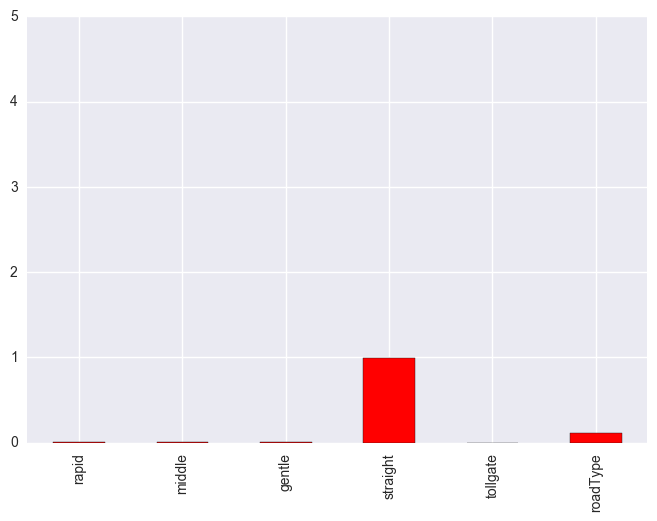

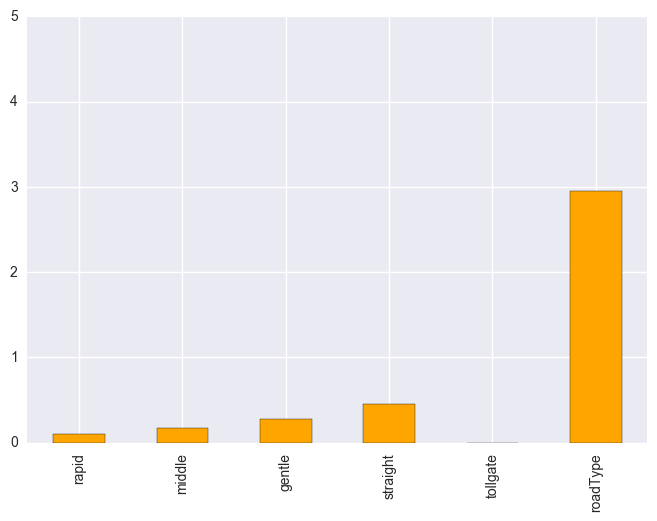

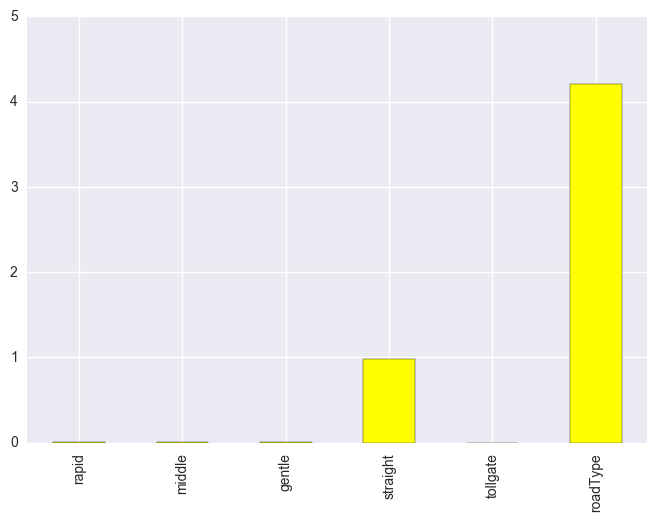

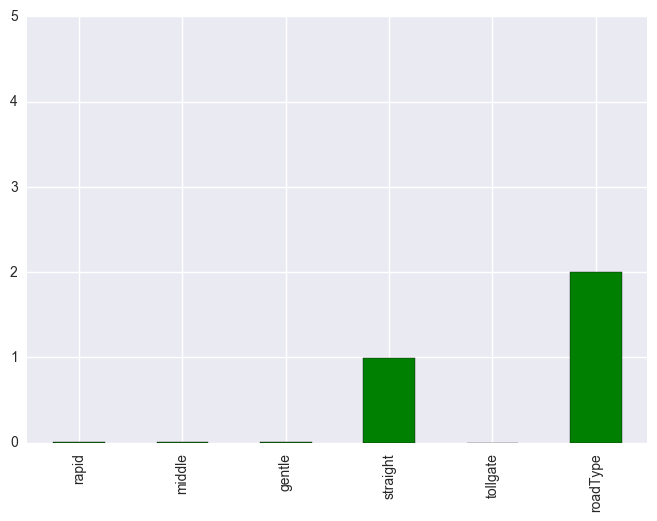

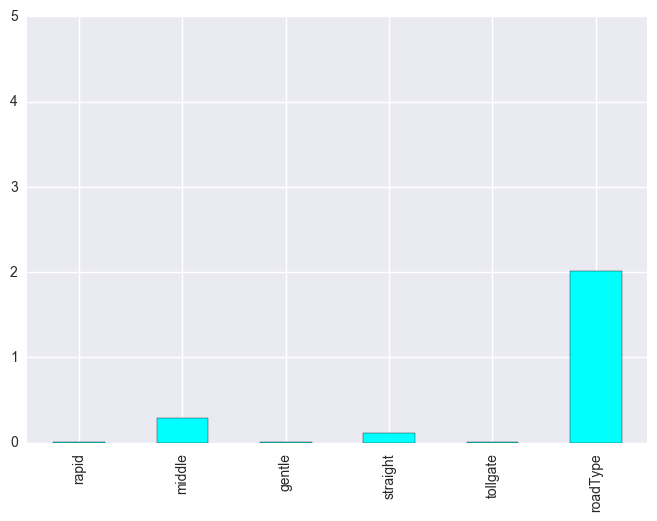

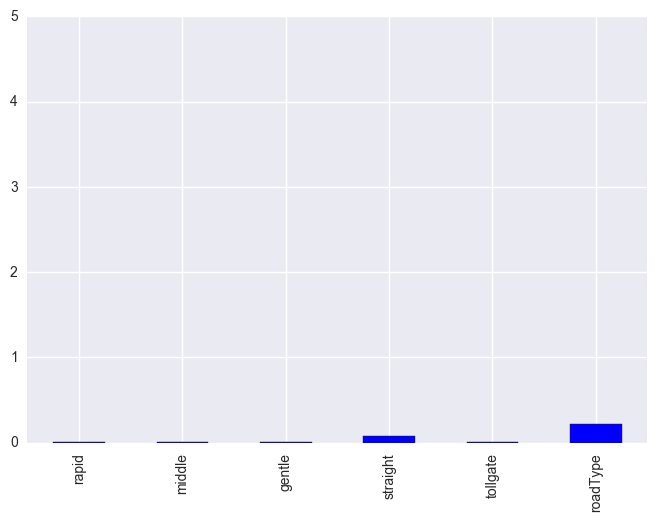

In [313]:
indices = ref.sort_values("weight", ascending=False).index.tolist()

ref = ref[["rapid", "middle", "gentle", "straight",  "tollgate", "roadType"]]
for n, id in enumerate(indices[:6]):
    ref.ix[id].plot(kind='bar', color=colors[n])
    plt.ylim(0, 5)
    plt.show()

In [291]:
pred = zip(mf.index, vb.predict(bf))
result = np.zeros(gridSize)

for index, klass in pred:
    result[index] = klass + 1
    
np.savetxt(targetDir + "clusters.csv", result, delimiter=",", fmt="%d")